In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
import sys
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from pandas import ExcelWriter
import traitlets
from ipywidgets import widgets
from IPython.display import display
from tkinter import Tk, filedialog
from sklearn.preprocessing import MinMaxScaler

In [12]:
def clean(data):

    #REMOVE DUMMY ENTRIES ***Version 3.1 Update***
    
    data = data[~data['SubCategory'].str.contains("DummyCategory")]

    #DUPLICATE USERS CHECK
    dc = data[['UserName','QuestionId']]
    dups = dc[dc.duplicated()]
    
    if(dups.empty == False):
        print('\n\n\033[1mDuplicate values in data! Check the following usernames:\033[0m')
        print(set(dups['UserName']))
        sys.exit()


    pc = data.pivot_table(index = "UserName", columns = "QuestionId", values = ["OptionNumber", "TimeTaken"])
    pc.columns.names = (None, None)

    #REMOVE USERS BASED ON TIME
    for user, time in pc['TimeTaken'].iterrows():
        count = 0
        #questions = time.count()
        for i in time:
            if i < 2: count += 1
        if count>20: #Condition Subject to Change
            pc.drop(user, inplace=True)

    #SAME ANSWER CHECK
    for user, option in pc['OptionNumber'].iterrows():
        count = [0,0,0,0,0]
        thresh = 0.8*option.count() #Threshold Subject to Change

        for i in option:
            if i==1:
                count[0] += 1
            if i==2:
                count[1] += 1
            if i==3:
                count[2] += 1
            if i==4:
                count[3] += 1
            if i==5:
                count[4] += 1

        if (count[0] > thresh) or (count[1] > thresh) or (count[2] > thresh) or (count[3] > thresh) or (count[4] > thresh):
            pc.drop(user, inplace=True)

    #PEOPLE TO KEEP
    keep = list(pc.index)

    pivot = data.pivot_table(index = "UserName", columns = ["Category", "SubCategory", "QuestionId"], values = "Marks")
    pivot.columns.names = (None, None, None)

    #KEEPING APPROVED USERS
    for user, item in pivot.iterrows():
        if user not in keep:
            pivot.drop(user, inplace= True)
            
    pivot.fillna(0, inplace=True)
    return pivot

In [13]:
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = list(filedialog.askopenfilename(multiple=False))

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
        
my_button = SelectFilesButton()
my_button

SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

In [222]:
path = my_button.files
path = ''.join(path)

print("\033[1mSelected file : \033[0m", path.split('/')[-1])

raw = pd.read_excel(path)

pivot = clean(raw) 


Selected file :  Passion.xlsx


In [223]:
heads = list(pivot.columns.levels[0])
lvls = list(pivot.columns.levels[1])

df = pd.DataFrame()
for i in range(len(heads)):
    a = pivot[heads[i]].sum(axis=1)
    a_min = min(a)
    a_max = max(a)
    den = a_max - a_min
    a = a.apply(lambda x: (x - a_min)/den)
    a = a.to_frame()
    df = pd.concat([df, a], axis=1)
    
df.columns = heads

In [228]:
df

,"Interest-A,","Interest-C,","Interest-E,","Interest-I,","Interest-R,","Interest-S,"
UserName,,,,,,
B11C1,0.271186,0.734375,0.333333,0.367647,0.298507,0.593023
B11C12,0.542373,0.828125,0.597701,0.544118,0.582090,0.639535
B11C19,0.135593,0.421875,0.057471,0.073529,0.253731,0.139535
B11C2,0.627119,0.796875,0.873563,0.911765,0.835821,0.930233
B11C20,0.474576,0.843750,0.850575,0.602941,0.507463,0.825581
B11C25,0.728814,0.734375,0.724138,0.705882,0.626866,0.837209
B11C28,0.423729,0.640625,0.471264,0.794118,0.417910,0.430233
B11C29,0.220339,0.546875,0.505747,0.676471,0.328358,0.418605
B11C3,0.559322,0.796875,0.609195,0.500000,0.492537,0.604651


In [229]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [230]:
principalDf

,principal component 1,principal component 2
UserName,,
B10B10,-0.484250,-0.166744
B10B11,-0.270442,-0.253605
B10B12,-0.323447,-0.253072
B10B13,0.349200,0.036332
B10B14,-0.023869,-0.332804
B10B15,0.053189,-0.479530
B10B16,-0.056774,-0.089963
B10B17,0.094039,-0.199233
B10B18,-0.231515,-0.540123


In [237]:
from sklearn.decomposition import PCA

pca = PCA(n_components=, svd_solver='full')

principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents)

principalDf.index = df.index

In [240]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.13412299 0.02328549 0.01753664 0.01431007 0.01057278 0.0079327 ]
[0.64556486 0.11207845 0.08440788 0.06887766 0.05088923 0.03818193]
[0.64556486 0.7576433  0.84205118 0.91092884 0.96181807 1.        ]


In [241]:
principalDf

,0,1,2,3,4,5
UserName,,,,,,
B11C1,0.355035,-0.114359,-0.199023,0.264455,0.034886,0.086997
B11C12,-0.107242,-0.042136,-0.020166,0.237725,-0.028755,-0.014364
B11C19,0.971077,-0.172078,0.111515,0.234390,0.035177,0.008726
B11C2,-0.642211,-0.088575,-0.030440,-0.025634,-0.079285,0.074757
B11C20,-0.268744,-0.010342,-0.198280,0.185478,-0.225373,0.096186
B11C25,-0.367324,0.111530,-0.015251,0.076005,-0.007978,0.080074
B11C28,0.112831,-0.087567,-0.097915,-0.084278,0.032172,-0.200219
B11C29,0.296309,-0.159805,-0.156897,-0.098395,-0.110253,-0.097770
B11C3,-0.031679,0.030921,-0.038850,0.240715,-0.061928,-0.022922


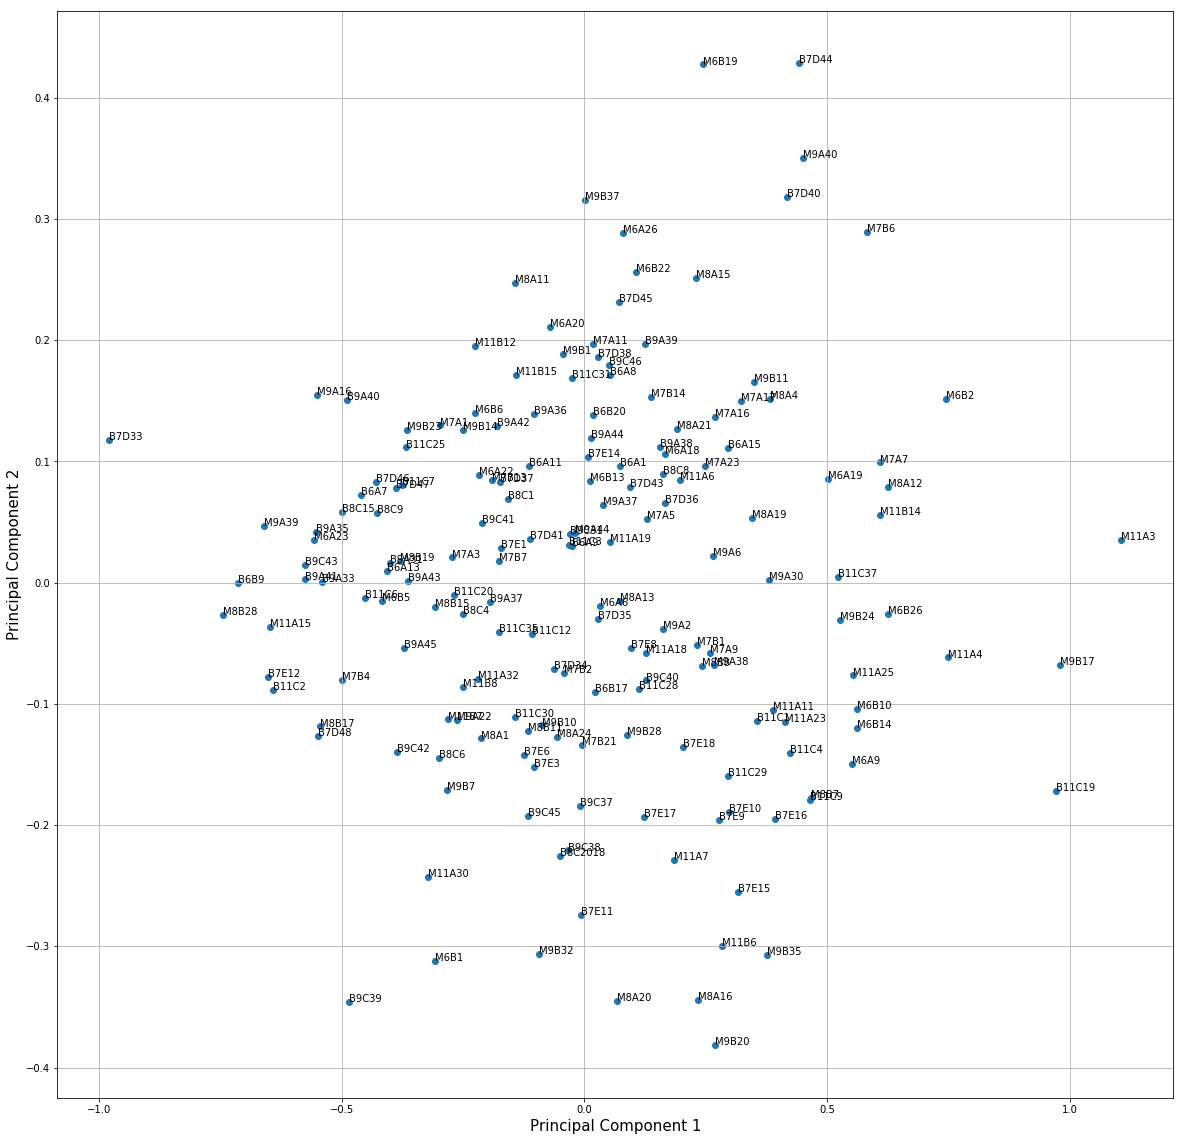

In [244]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = df.index
colors = ['r', 'g', 'b']
ax.scatter(principalDf[principalDf.columns[0]], principalDf[principalDf.columns[1]])
ax.grid()

for i, txt in enumerate(list(df.index)):
    ax.annotate(txt, (principalDf[principalDf.columns[0]].iloc[i],principalDf[principalDf.columns[1]].iloc[i]))

In [307]:
#Correlation circle using Prince package

import prince

#for loop to check cumulative variance explained > 70%

for i in range(1, len(heads)):
    pca2 = prince.PCA(df, n_components=i)
    if pca2.cumulative_explained_inertia[i-1]>=0.7:
        break

(<matplotlib.figure.Figure at 0x19f826540f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f84217240>)

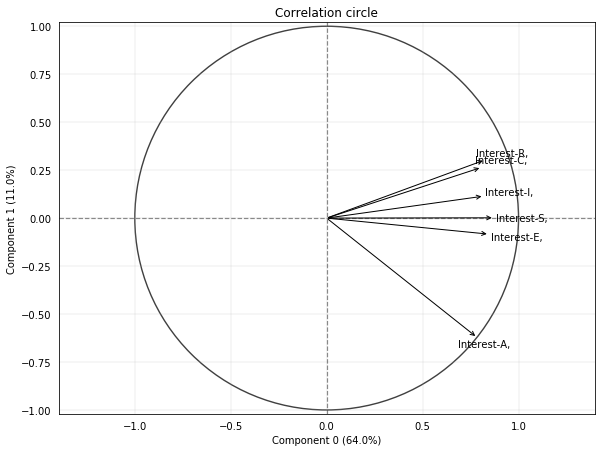

In [295]:
pca2.plot_correlation_circle()

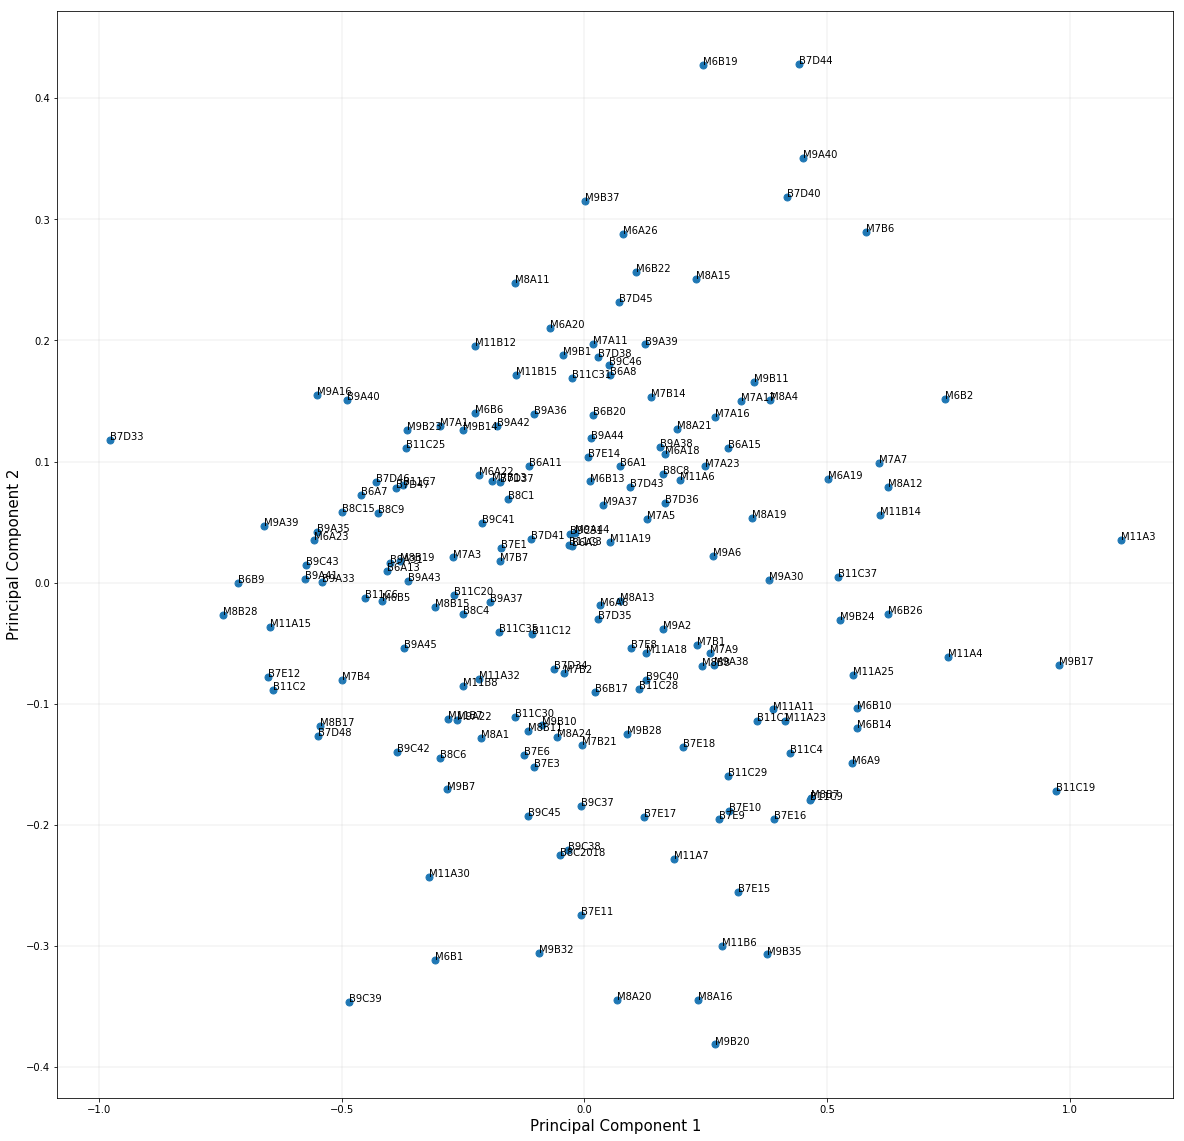

In [306]:
#Same plot using Prince PCA

df2 = pca2.row_principal_coordinates

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = df2.index
colors = ['r', 'g', 'b']
ax.scatter(principalDf[principalDf.columns[0]], principalDf[principalDf.columns[1]])
ax.grid()

for i, txt in enumerate(list(df2.index)):
    ax.annotate(txt, (principalDf[principalDf.columns[0]].iloc[i],principalDf[principalDf.columns[1]].iloc[i]))
    

